In [3]:
import pandas as pd
import numpy as np
from simbad_download import fetch_object_children
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List
from astropy.table import Table
from astropy.io import ascii

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

In [123]:
GAIA_EDR3_BIBCODE: str = '2020yCat.1350....0G'

In [4]:
RA: float = 11.7980
DEC: float = 85.2440
    
COLUMNS: List[str] = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
MIN_PARALLAX: float = 0.25
MAX_PARALLAX: float = 0.75
    
CLUSTER_NAME: str = 'NGC 188'
DEGREES: int = 1

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [5]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/2_deg.csv', index_col=None)

In [6]:
sources.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 574509467058245248,574509467058245248,1493410390,2016.0,35.762865,0.029851,85.164665,0.029967,0.545239,...,0.2303,0.2003,0.2590,0.1852,0.1610,0.2085,0.0981,0.0852,0.1104,MARCS
1,1636148068921376768,Gaia DR3 574509467058245632,574509467058245632,671685054,2016.0,35.689345,0.127046,85.157645,0.129013,0.276671,...,0.3949,0.3600,0.4324,0.2899,0.2639,0.3176,0.1549,0.1415,0.1696,MARCS
2,1636148068921376768,Gaia DR3 574509497122165760,574509497122165760,998946401,2016.0,35.790532,0.125888,85.170221,0.133328,0.700458,...,0.0185,0.0049,0.0432,0.0132,0.0035,0.0310,0.0071,0.0019,0.0167,PHOENIX
3,1636148068921376768,Gaia DR3 574509634560358272,574509634560358272,1157546964,2016.0,35.942416,0.145537,85.191924,0.142934,0.419366,...,0.0033,0.0008,0.0093,0.0024,0.0006,0.0068,0.0013,0.0003,0.0037,PHOENIX
4,1636148068921376768,Gaia DR3 574512555138118272,574512555138118272,1114709481,2016.0,35.841332,0.352966,85.192230,0.388702,0.268799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

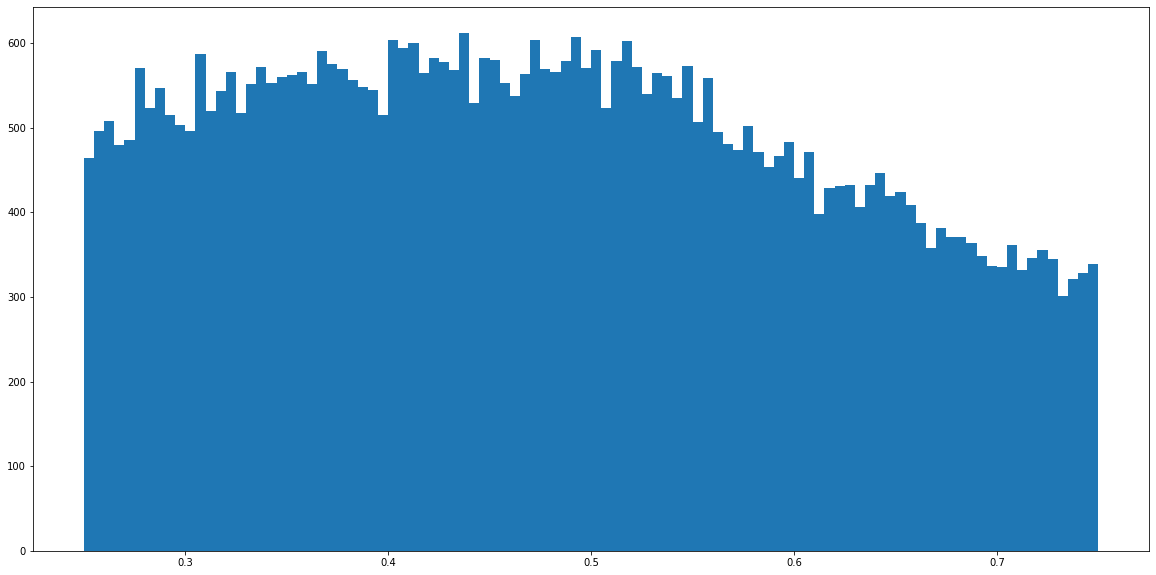

In [127]:
plt.figure(figsize=(20, 10))
plt.hist(sources.parallax, bins=100);

The NGC 188 cluster's parallax is at ~0.5 mas. I am using a broad filter of (0.25, 0.75) mas for the parallax.

In [68]:
def filter_by_parallax(sources: pd.DataFrame,
                       min_parallax: float,
                       max_parallax: float) -> pd.DataFrame:
    sources_par = sources[(sources['parallax']>min_parallax) & (sources['parallax']<max_parallax)]
    print(f'After parallax filtering: {len(sources_par)}')
    return sources_par

def clean_nans(sources: pd.DataFrame,
               columns: List[str]) -> pd.DataFrame:
    sources_clean = sources.dropna(subset=columns)
    print(f'After dropping NaNs from {columns}: {len(sources_clean)}')
    return sources_clean

def wrap_coordinates(sources: pd.DataFrame) -> pd.DataFrame:
    sources_wrapped = sources.copy()
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources['ra'].values,
                                          dec=sources['dec'].values,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    
        
    sources_wrapped.ra = sky_coords.ra.wrap_at(180 * u.deg).value
    return sources_wrapped

def normalize(sources: pd.DataFrame,
              columns: List[str],
              with_errors: bool = False) -> pd.DataFrame:
    scaler = StandardScaler()
    
    s = scaler.fit_transform(sources[columns])
    
    if with_errors:
        err_columns = [f'{c}_error' for c in columns]
        rescaled_errors = sources[err_columns].values*scaler.scale_
        s = np.concatenate([s, rescaled_errors], axis=1)
    return s

def prepare_data_for_clustering(sources: pd.DataFrame,
                                min_parallax: float,
                                max_parallax: float,
                                columns: List[str]) -> pd.DataFrame:
    return wrap_coordinates(
        clean_nans(
            filter_by_parallax(sources, min_parallax, max_parallax),
            columns
        )
    )

In [70]:
sources_to_cluster = prepare_data_for_clustering(sources, MIN_PARALLAX, MAX_PARALLAX, COLUMNS)
sources_normalized = normalize(sources_to_cluster, COLUMNS)

After parallax filtering: 49649
After dropping NaNs from ['ra', 'dec', 'parallax', 'pmra', 'pmdec']: 49649


The clustering is performing using 5 astrometric parameters of $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$.

Normalization scales the features to an unit variance.

In [71]:
def plot_on_aitoff(sources: pd.DataFrame, cluster_name: str, degrees: float):
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources.ra,
                                          dec=sources.dec,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    plt.figure(figsize=(10, 7));
    plt.subplot(111, projection="aitoff");
    plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon',
                label=f'{cluster_name} center$\pm {degrees}^\circ$');
    plt.grid();
    plt.legend(loc='lower right', fontsize=14);

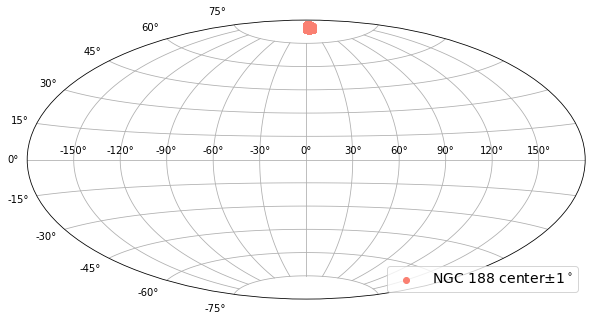

In [72]:
plot_on_aitoff(sources_to_cluster, CLUSTER_NAME, DEGREES)

# Comparision: NGC 188 cluster members from literature

In [73]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


# DBSCAN

In [74]:
def dbscan(sources: pd.DataFrame, eps: float = 0.5, min_samples=20) -> np.array:
    dbscan_clust = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_fit = dbscan_clust.fit(sources)

    dbscan_labels = dbscan_fit.labels_
    unique_labels = set(dbscan_labels)
    print(f'Classified into {len(unique_labels)} labels: {unique_labels}')
    return dbscan_labels

def label_sources(sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    sources_labelled = pd.DataFrame(columns=[*sources.columns, 'label'],
                                    data=np.concatenate([sources,
                                                         labels.reshape((-1, 1))], axis=1))
    sources_labelled['label'] = sources_labelled.label.astype(int)
    return sources_labelled

def get_clustered_and_noise(labelled_sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    non_noise_labels: np.array = labels[labels!=-1]
    unique_label_count = np.unique(non_noise_labels, return_counts=True)
    largest_non_noise: int = unique_label_count[0][np.argmax(unique_label_count[1])]
    
    clustered: pd.DataFrame = labelled_sources[labelled_sources['label']==largest_non_noise]
    noise: pd.DataFrame = labelled_sources[labelled_sources['label']!=largest_non_noise]
        
    print(f'Clustered: {len(clustered)}/{len(labelled_sources)}')
        
    return clustered, noise

In [75]:
def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

In [76]:
def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

def check_for_undiscovered_sources(from_lit: pd.DataFrame,
                                   cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(from_lit, 'EDR3 id')
    in_cluster = np.vectorize(is_in_cluster)(cluster_sources['source_id'].values)
    falses = in_cluster[~in_cluster]
    print(f'{len(falses)}/{len(in_cluster)} objects were previously unreported.')
    return len(falses)/len(in_cluster)

In [77]:
is_in_edr3 = is_in_cluster_function(sources_to_cluster)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [78]:
labels = dbscan(sources_normalized, eps=.5, min_samples=200)
labelled_sources = label_sources(sources_to_cluster, labels)
clustered, noise = get_clustered_and_noise(labelled_sources, labels)

in_cluster = check_for_cluster_children(from_lit_edr3, clustered)
# undiscovered = check_for_undiscovered_sources(from_lit, clustered)

Classified into 2 labels: {0, -1}
Clustered: 1818/49649
1170/1327 objects found in the cluster.


In [79]:
from_lit_edr3[~in_cluster].reported.value_counts()

1    153
2      2
3      2
Name: reported, dtype: int64

In [80]:
def cluster_plot(clustered_sources: pd.DataFrame,
                 noise_sources: pd.DataFrame,
                 paper_sources: pd.DataFrame):
    plt.figure(figsize=(20, 10))
    plt.scatter(clustered_sources.ra, clustered_sources.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
    plt.scatter(noise_sources.ra, noise_sources.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
    plt.scatter(paper_sources.ra, paper_sources.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
    lgnd = plt.legend(fontsize=14);
    plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
    plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

    for handle in lgnd.legendHandles:
        handle._sizes = [30];

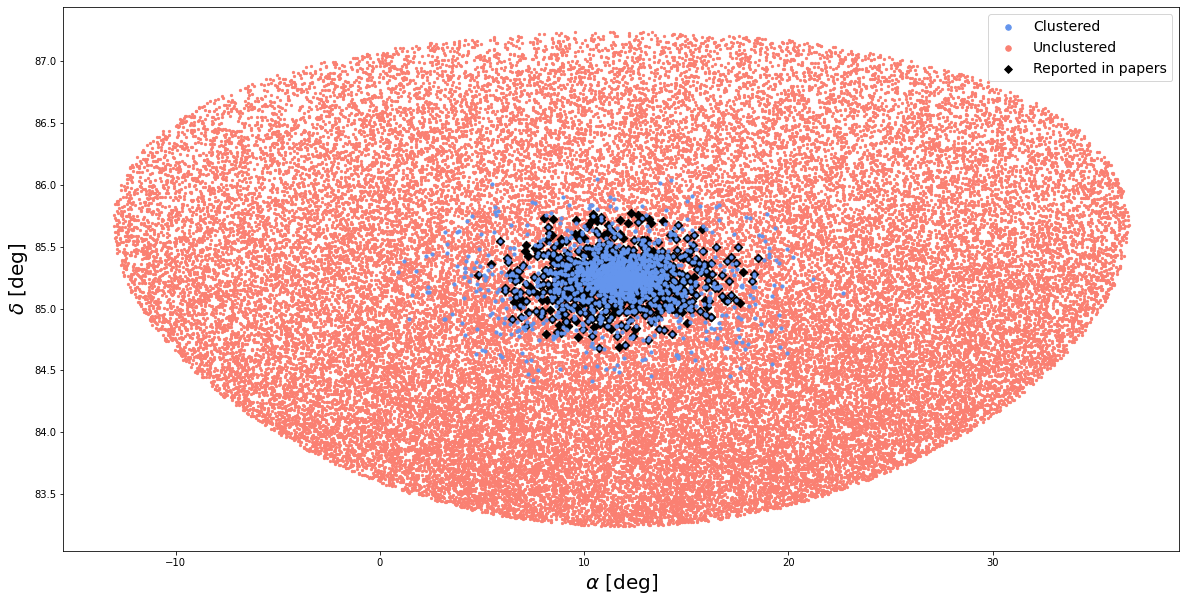

In [86]:
cluster_plot(clustered, noise, from_lit_edr3)

In [88]:
clustered.to_csv('./data/ngc_188/dbscan_clustered.csv')

## HR diagram

In [162]:


clustered['color'] = clustered.phot_bp_mean_mag-clustered.phot_rp_mean_mag
clustered['extinction_coefficient'] = extinction_coefficient(clustered.ra.values,
                                                             clustered.dec.values,
                                                             1/clustered.parallax.values)
clustered['g_ext'] = gaia_g_extinction(clustered.extinction_coefficient.values)
clustered['reddening'] = gaia_extinction(clustered.extinction_coefficient.values)
clustered['absolute_magnitude'] = absolute_magnitude(clustered.phot_g_mean_mag,
                                                     clustered.g_ext,
                                                     clustered.parallax.values.astype(np.float32))


/tmp/ipykernel_6659/1323368515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['color'] = clustered.phot_bp_mean_mag-clustered.phot_rp_mean_mag
/tmp/ipykernel_6659/1323368515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['extinction_coefficient'] = extinction_coefficient(clustered.ra.values,
/tmp/ipykernel_6659/1323368515.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

(array([ 28.,  43., 209., 632., 574., 229.,  56.,  31.,  12.,   4.]),
 array([0.2116997 , 0.24069871, 0.26969773, 0.29869673, 0.32769573,
        0.35669476, 0.38569376, 0.41469276, 0.44369176, 0.4726908 ,
        0.5016898 ], dtype=float32),
 <BarContainer object of 10 artists>)

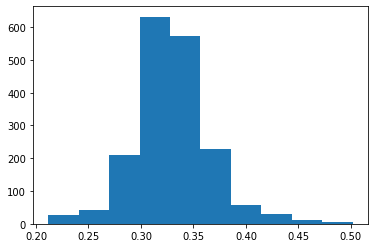

In [163]:
plt.hist(clustered.reddening)

In [175]:
def plot_hr(sources: pd.DataFrame):
    plt.figure(figsize=(10, 10))
    plt.scatter(sources.color, sources.absolute_magnitude,
                s=10., color='royalblue', marker='*', alpha=.1)
    plt.scatter(sources.color-sources.reddening, sources.absolute_magnitude,
                s=10., color='mediumvioletred', marker='*', alpha=.5)
    plt.gca().invert_yaxis()
    plt.gca().set_xlabel('B-R [mag]', fontsize=14);
    plt.gca().set_ylabel('absolute magnitude [mag]', fontsize=14);

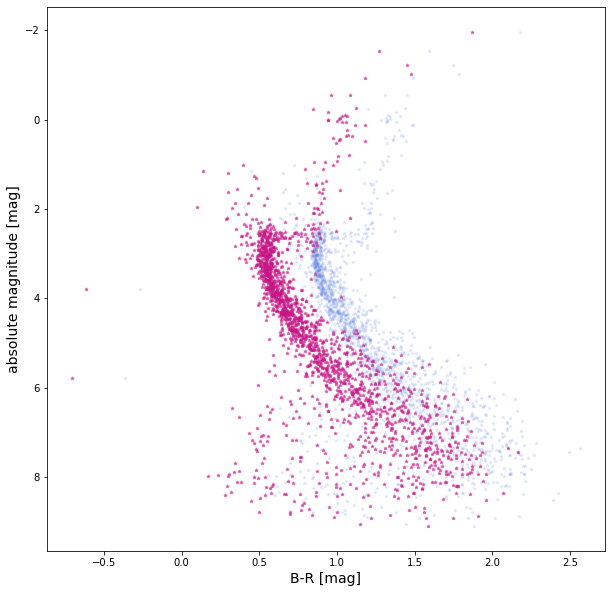

In [176]:
plot_hr(clustered)

In [204]:
blue_stragglers = clustered[((clustered.absolute_magnitude<2.3) & (clustered.color-clustered.reddening<0.75)) |
                            ((clustered.absolute_magnitude<3.75) & (clustered.color-clustered.reddening<0.45))]

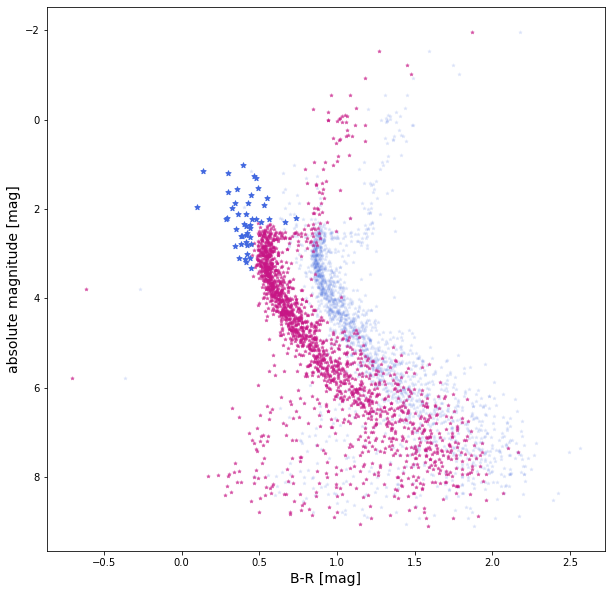

In [205]:
plot_hr(clustered)
plt.scatter(blue_stragglers.color-blue_stragglers.reddening, blue_stragglers.absolute_magnitude,
            s=30., color='royalblue', marker='*');

In [228]:
len(blue_stragglers)

46

In [229]:
sources_to_cluster.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_bp_mean_mag,phot_g_mean_mag,phot_rp_mean_mag
0,574509467058245248,35.762865,85.164665,0.545239,0.034492,3.247654,0.041664,-1.847557,0.038611,16.705692,16.236290,15.618303
1,574509467058245632,35.689345,85.157645,0.276671,0.148588,-5.039717,0.173523,7.691300,0.160283,18.508620,17.830448,16.846645
2,574509497122165760,35.790532,85.170221,0.700458,0.150817,1.392000,0.170484,-5.308261,0.161823,19.649704,18.766980,17.912611
3,574509634560358272,35.942416,85.191924,0.419366,0.161032,-2.333778,0.197738,5.039330,0.184551,19.442898,18.680151,17.841805
4,574512555138118272,35.841332,85.192230,0.268799,0.390828,-3.001610,0.471978,0.156632,0.481216,20.700583,20.057280,19.029911


In [178]:
blue_stragglers['extinction'] = extinction_coefficient(blue_stragglers['ra'].values,
                                                       blue_stragglers['dec'].values,
                                                       1/blue_stragglers['parallax'].values)

/tmp/ipykernel_6659/456296860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blue_stragglers['extinction'] = extinction_coefficient(blue_stragglers['ra'].values,


In [199]:
blue_stragglers.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_bp_mean_mag,phot_g_mean_mag,phot_rp_mean_mag,label,color,extinction_coefficient,g_ext,reddening,absolute_magnitude
33194,5.735490e+17,9.880612,84.826773,0.488820,0.017106,-2.079892,0.019703,0.099430,0.019495,14.975012,14.689231,14.237548,0,0.737464,0.11,0.796696,0.337112,2.338282
34044,5.735831e+17,4.161714,84.788042,0.543177,0.019972,-3.382949,0.025265,-0.041366,0.024812,15.304901,14.976786,14.480428,0,0.824473,0.14,0.861766,0.378539,2.789728
34523,5.736022e+17,3.193740,84.911792,0.570662,0.015588,-2.318896,0.019962,-1.808590,0.018866,14.816711,14.377251,13.770253,0,1.046458,0.14,0.861766,0.378539,2.297381
34916,5.736182e+17,4.879116,85.158393,0.497824,0.017588,-1.321872,0.020673,-2.354717,0.021901,14.760699,14.519563,14.128537,0,0.632162,0.11,0.796696,0.337112,2.208246
34983,5.736207e+17,5.713011,85.130337,0.502753,0.014992,-2.954898,0.017608,-0.006889,0.018806,14.674288,14.406227,13.976914,0,0.697374,0.11,0.796696,0.337112,2.116306


In [85]:
sources_normalized = normalize(sources_to_cluster, COLUMNS, True)
data = Table()
data['_x'] = sources_normalized[:, 0]
data['_y'] = sources_normalized[:, 1]
data['Plx'] = sources_normalized[:, 2]
data['pmRA'] = sources_normalized[:, 3]
data['pmDE'] = sources_normalized[:, 4]
data['e_Plx'] = sources_normalized[:, 7]
data['e_pmRA'] = sources_normalized[:, 8]
data['e_pmDE'] = sources_normalized[:, 9]
ascii.write(data, 'pyUPMASK/input/ngc_188.dat', overwrite=True) 

# pyUPMASK

In [83]:
pyupmask_clustered = ascii.read('pyUPMASK/output/ngc_188.dat').to_pandas()

In [84]:
len(pyupmask_clustered[pyupmask_clustered.probs_final>0.9])

1528

In [217]:
CLUSTER_THRESHOLD: float = 0.75
labels_pyupmask = (pyupmask_clustered.probs_final>CLUSTER_THRESHOLD).astype(int).values-1
    
labelled_sources_pyupmask = label_sources(sources_to_cluster,
                                          labels_pyupmask)
clustered_pyupmask, noise_pyupmask = get_clustered_and_noise(labelled_sources_pyupmask,
                                                             labels_pyupmask)

r = check_for_cluster_children(from_lit_edr3, clustered)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 49649 and the array at index 1 has size 13684

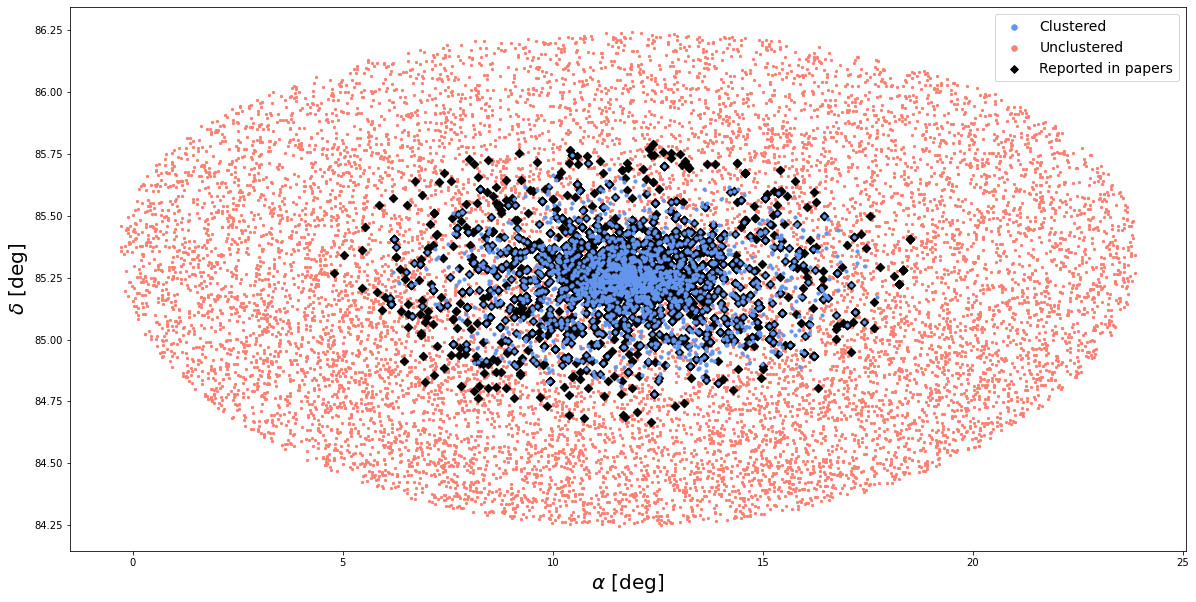

In [28]:
cluster_plot(clustered_pyupmask, noise_pyupmask, cluster_children)

# HDBSCAN

In [224]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=300, allow_single_cluster=True)

In [225]:
labels_hdbscan = clusterer.fit_predict(sources_normalized)
labelled_sources_hdbscan = label_sources(sources_to_cluster, labels_hdbscan)
clustered_hdbscan, noise_hdbscan = get_clustered_and_noise(labelled_sources_hdbscan, labels_hdbscan)

r = check_for_cluster_children(from_lit_edr3, clustered_hdbscan)

Clustered: 1641/49649
1058/1327 objects found in the cluster.


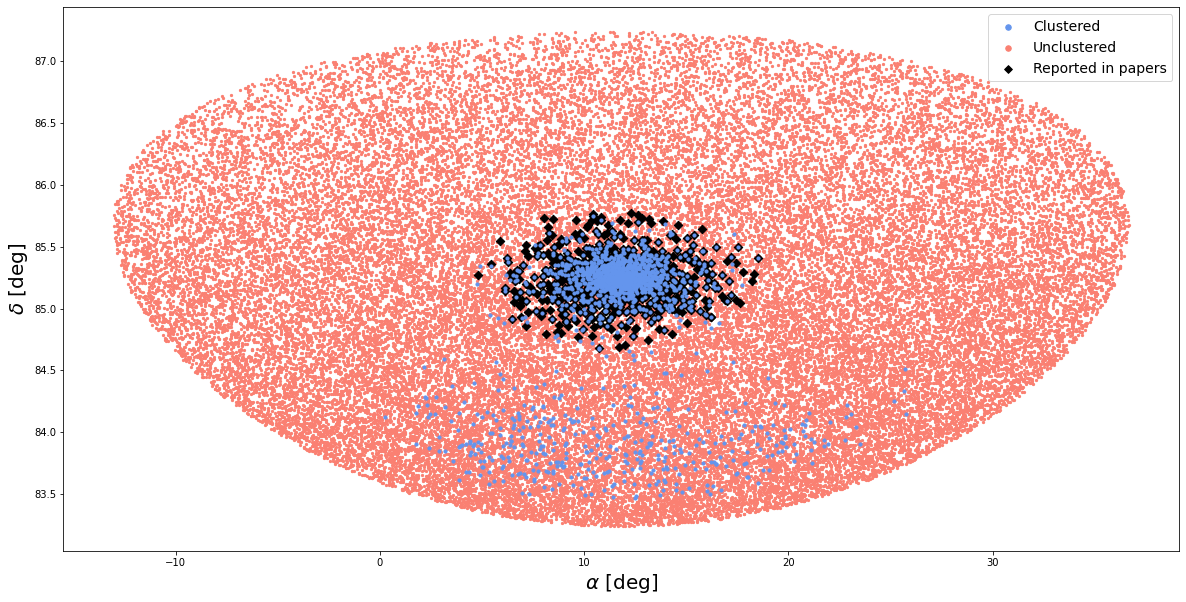

In [226]:
cluster_plot(clustered_hdbscan, noise_hdbscan, from_lit_edr3)